In [1]:
# probably won't need all of this stuff, but why not import it all?

import SD_raster_loading
import SD_NC_loading
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dalecLoad
import spectralConv

In [2]:
SD_directory = 'C:/Users/daa5/\
OneDrive - University of Stirling/\
PlanetData/\
Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/\
acolite_output/'

file = 'PlanetScope_227a_2022_08_13_11_13_41_L2R.nc' # from 13th Aug, which corresponds to DALEC log 87

f = netCDF4.Dataset(SD_directory+file)
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    generated_by: ACOLITE
    generated_on: 2022-08-24 10:58:27 GMT Summer Time
    contact: Quinten Vanhellemont
    product_type: NetCDF
    metadata_profile: beam
    metadata_version: 0.5
    auto_grouping: rhot:rhorc:rhos:rhow:Rrs
    Conventions: CF-1.7
    sensor: PlanetScope_SD8
    satellite_sensor: PlanetScope_227a
    isodate: 2022-08-13T11:13:41+00:00
    sza: 43.67708
    vza: 4.941244
    raa: 139.06694
    se_distance: 1.0132199756116838
    mus: 0.7232434613772802
    acolite_file_type: L2R
    oname: PlanetScope_227a_2022_08_13_11_13_41
    ofile: C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_227a_2022_08_13_11_13_41_L2R.nc
    Coastal-Blue_wave: 443.6610607244119
    Coastal-Blue_name: 444
    Coastal-Blue_f0: 19014.80145243501
    Blue_wave: 492.3012651262192
    Blue_name: 492
    Blue_f0: 19688.

In [3]:
print(f.variables.keys()) # get all variable names

dict_keys(['transverse_mercator', 'x', 'y', 'lon', 'lat', 'rhot_444', 'rhos_444', 'rhot_492', 'rhos_492', 'rhot_533', 'rhos_533', 'rhot_566', 'rhos_566', 'rhot_612', 'rhos_612', 'rhot_666', 'rhos_666', 'rhot_707', 'rhos_707', 'rhot_866', 'rhos_866'])


In [4]:
coord = [56.14693897799395, -3.923458784671348] # this is approx the location of the DALEC
coord2 = [56.146746528609306, -3.92285731543299] # this is perhaps a deeper part of the loch

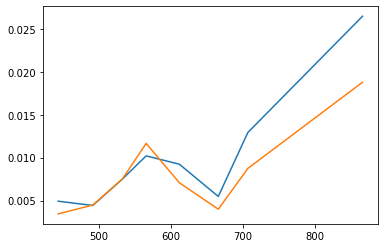

In [5]:
SD_spect1 = SD_NC_loading.get_SD_NC_Spectra(f, coord[0], coord[1])
SD_spect2 = SD_NC_loading.get_SD_NC_Spectra(f, coord2[0], coord2[1])           

plt.plot(SD_spect1['Wavelength'], SD_spect1['Rho_s']/np.pi)
plt.plot(SD_spect2['Wavelength'], SD_spect2['Rho_s']/np.pi)
plt.show()

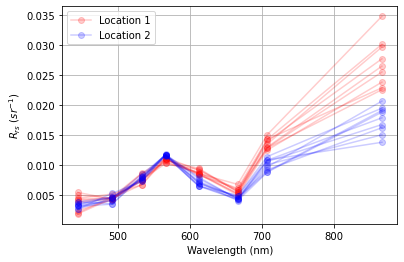

In [6]:
# let's load a 3x3 grid of pixels
SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3)) 
SD_spect2 = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord2[0], coord2[1], shape=(3, 3)) 



fig, ax = plt.subplots()

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='Location 2',
            marker='o',
            alpha=0.2)
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')


# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

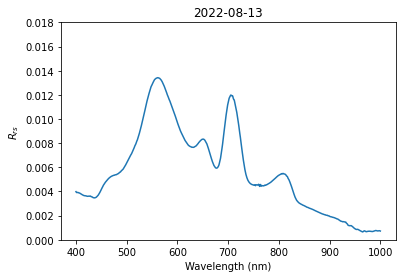

In [7]:
# let's check out the corresponding log file!
filepath = 'data/Jul-Aug/LOG_0087.dtf'
log87 = dalecLoad.load_DALEC_log(filepath)
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths(filepath)
mean_spect = dalecLoad.uniform_grid_spectra_mean(log87, spect_wavelengths)

fig, ax = plt.subplots()

ax.plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'])
ax.set_title(str(log87[' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol
ax.set_ylim(0, 0.018)
ax.set_ylabel('$R_{rs}$')
ax.set_xlabel('Wavelength (nm)')       

plt.show()

In [8]:
log87.loc[:, 'Lsky', :]['Spectral Magnitude']

Sample #
66242    0.074951
66242    0.075344
66242    0.072599
66242    0.069296
66242    0.071590
           ...   
73863    0.003857
73863    0.006433
73863    0.004211
73863    0.001639
73863    0.003976
Name: Spectral Magnitude, Length: 1524400, dtype: float64

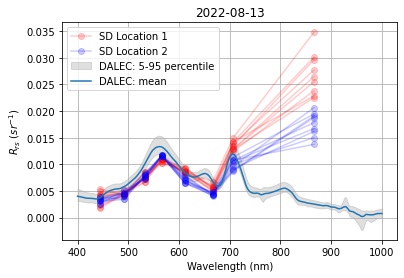

In [9]:
# and plot together: LOOKS ALRIGHT...

fig, ax = plt.subplots()

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SD Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='SD Location 2',
            marker='o',
            alpha=0.2)
    

df_summary = dalecLoad.uniform_grid_spectra_stats(log87, spect_wavelengths, percentiles=[.05, .25, .5, .75, .95])

ax.fill_between(df_summary['wavelength'], df_summary['5%'], y2=df_summary['95%'],
                   color='gray', alpha=0.25, label='DALEC: 5-95 percentile')


ax.plot(df_summary['wavelength'], df_summary['mean'], label='DALEC: mean')
    
#ax.plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'], label='DALEC mean')
ax.set_title(str(log87[' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol

    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')


# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

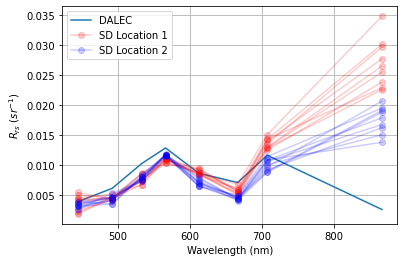

In [10]:
# now let's see what happens when we do the convolution on the DALEC data

RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')
DALEC_SD = spectralConv.SD_band_calc(RSR_doves, mean_spect['Rrs_mean'].values,
                                     RSR_doves['Wavelength (nm)'].values)


fig, ax = plt.subplots()

ax.plot(SD_spect['Wavelength'], DALEC_SD, label='DALEC')

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SD Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='SD Location 2',
            marker='o',
            alpha=0.2)
    

    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')
    
# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

In [11]:
# now gonna try to look at all SD files:
import os
SD_files = []
for file in os.listdir(SD_directory):
    if file.endswith("L2R.nc"):
        SD_files.append(os.path.join(SD_directory, file))
SD_files

['C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_227a_2022_08_13_11_13_41_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2427_2022_08_11_10_28_21_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2427_2022_08_11_10_28_23_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2432_2022_08_10_10_27_06_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2436_2022_08_20_10_26_47_L2R.nc',
 'C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2482_2022_08_17_11_0

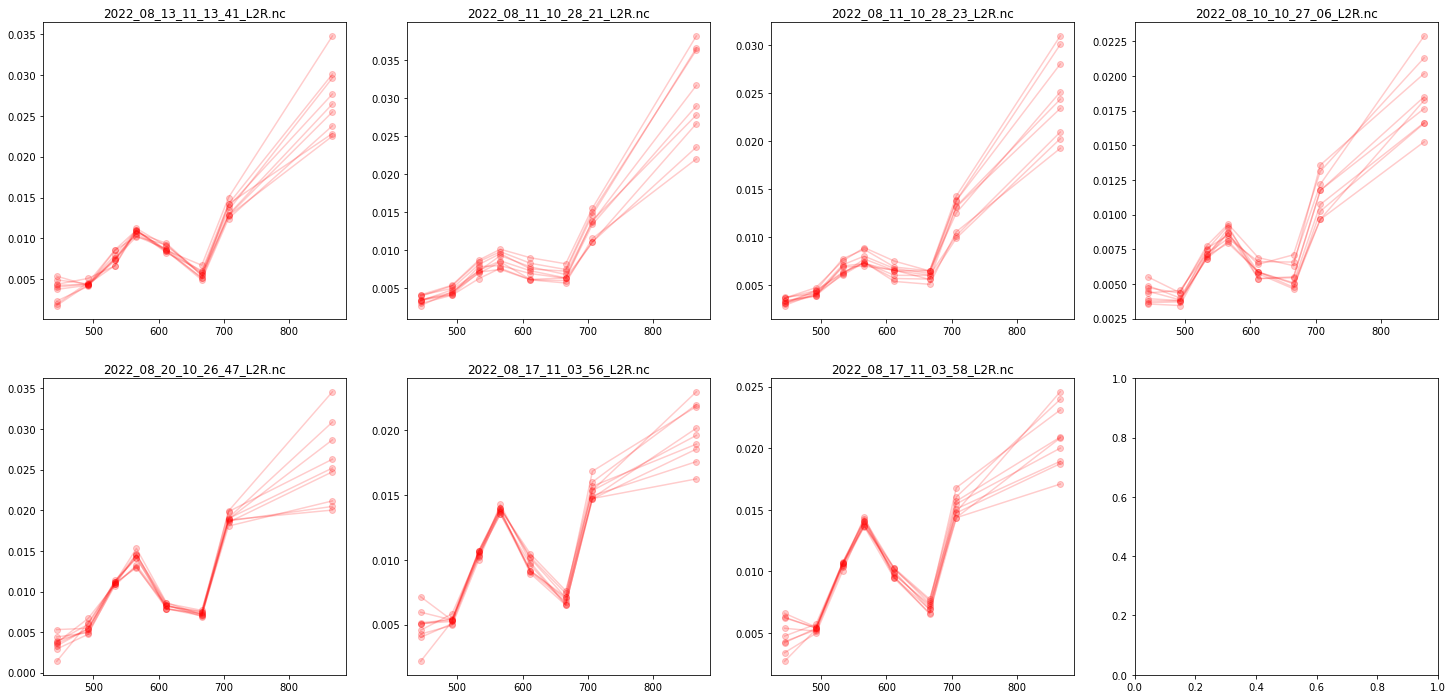

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(25, 12))

ax = ax.flatten()

for i in range(len(SD_files)):
    f = netCDF4.Dataset(SD_files[i])
    SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3)) 
    
    for col in list(SD_spect.columns.values)[1:]:
        ax[i].plot(SD_spect['Wavelength'],
                 SD_spect[col]/np.pi,
                 color='red',
                 label='Location 1',
                 marker='o',
                 alpha=0.2)
    
    ax[i].set_title(SD_files[i][-26:]) # note that currently files aren't in the right order... this is annoying!
plt.show()

In [13]:
# so it's pretty easy to get the datetime from the loaded ncdf file:
# just need to think of some nice way to load in the data so that it has the date attached to it
pd.to_datetime(f.isodate)

Timestamp('2022-08-17 11:03:58+0000', tz='UTC')

In [14]:
# should really use list comprehensions a bit more but this works for now
ncdf_dates = []
indexes = []
SD_spect_list = []

for i in range(len(SD_files)):
    f = netCDF4.Dataset(SD_files[i])
    SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3))
    ncdf_dates.append(f.isodate)
    indexes.append(i)
    SD_spect_list.append(SD_spect)

In [15]:
print(ncdf_dates)
print(indexes)
print(sorted(ncdf_dates))

['2022-08-13T11:13:41+00:00', '2022-08-11T10:28:21+00:00', '2022-08-11T10:28:23+00:00', '2022-08-10T10:27:06+00:00', '2022-08-20T10:26:47+00:00', '2022-08-17T11:03:56+00:00', '2022-08-17T11:03:58+00:00']
[0, 1, 2, 3, 4, 5, 6]
['2022-08-10T10:27:06+00:00', '2022-08-11T10:28:21+00:00', '2022-08-11T10:28:23+00:00', '2022-08-13T11:13:41+00:00', '2022-08-17T11:03:56+00:00', '2022-08-17T11:03:58+00:00', '2022-08-20T10:26:47+00:00']


In [16]:
# some naughty sorting code

indexes_sorted = [x for _, x in sorted(zip(ncdf_dates, indexes))]
indexes_sorted

[3, 1, 2, 0, 5, 6, 4]

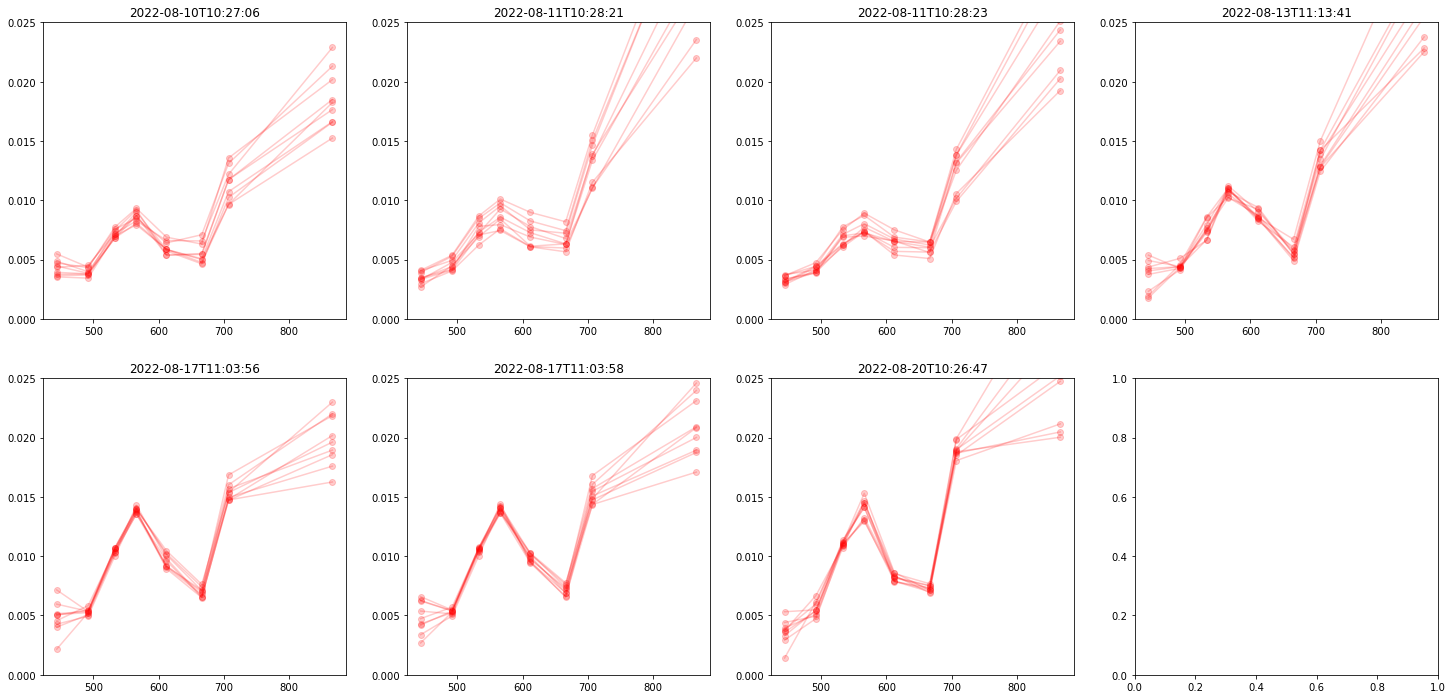

In [17]:
# now plot the SD files in the right order!

SD_spect_list_sorted = [x for _, x in sorted(zip(ncdf_dates, SD_spect_list))]
sorted_dates = sorted(ncdf_dates)

fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = ax.flatten()

for i in range(len(SD_files)):
    SD_spect = SD_spect_list_sorted[i]
    date = sorted_dates[i]
    
    for col in list(SD_spect.columns.values)[1:]:
        ax[i].plot(SD_spect['Wavelength'],
                 SD_spect[col]/np.pi,
                 color='red',
                 label='Location 1',
                 marker='o',
                 alpha=0.2)
        
    
    ax[i].set_title(str(date)[:19])
    ax[i].set_ylim([0, 0.025])
plt.show()

In [18]:
SD_spect

,Wavelength,rho_s_49_86,rho_s_49_87,rho_s_49_88,rho_s_50_86,rho_s_50_87,rho_s_50_88,rho_s_51_86,rho_s_51_87,rho_s_51_88
0,444.0,0.011257653,0.016698709,0.011628192,0.009181508,0.012369114,0.011961633,0.013850219,0.010368103,0.004429093
1,492.0,0.016946774,0.017212091,0.020990163,0.014889763,0.01601799,0.01873718,0.015520299,0.017079439,0.01926745
2,533.0,0.03456989,0.0357092,0.0341555,0.034431767,0.035191376,0.03501876,0.033671983,0.034362707,0.03491518
3,566.0,0.040657233,0.044314962,0.045615423,0.04104427,0.04449072,0.046072237,0.041642357,0.04547486,0.04807457
4,612.0,0.025645854,0.025868488,0.026833111,0.024829421,0.024755195,0.024680968,0.0260169,0.026276622,0.027092785
5,666.0,0.023573374,0.023650728,0.02411484,0.022490267,0.022026004,0.023031853,0.022799749,0.021755166,0.022412894
6,707.0,0.06256248,0.059902243,0.059370045,0.06231698,0.059656624,0.05818263,0.05908345,0.058714952,0.056749195
7,866.0,0.10866624,0.09695275,0.09008233,0.08258934,0.07917553,0.07771993,0.06292179,0.06432454,0.06645618


In [19]:
# now I'm going to see if I can make a nice dataframe which includes datetime...

SD_df = SD_spect.copy()
SD_df['Date'] = pd.to_datetime(date)
SD_df['Date'] = SD_df['Date'].dt.date # just removes the time aspect from the variable
SD_df.set_index(['Date', 'Wavelength'], inplace=True)
SD_df.index
SD_df

rho_s_49_86  rho_s_49_87  rho_s_49_88  rho_s_50_86  \
Date       Wavelength                                                       
2022-08-20 444.0       0.011257653  0.016698709  0.011628192  0.009181508   
           492.0       0.016946774  0.017212091  0.020990163  0.014889763   
           533.0        0.03456989    0.0357092    0.0341555  0.034431767   
           566.0       0.040657233  0.044314962  0.045615423   0.04104427   
           612.0       0.025645854  0.025868488  0.026833111  0.024829421   
           666.0       0.023573374  0.023650728   0.02411484  0.022490267   
           707.0        0.06256248  0.059902243  0.059370045   0.06231698   
           866.0        0.10866624   0.09695275   0.09008233   0.08258934   

                       rho_s_50_87  rho_s_50_88  rho_s_51_86  rho_s_51_87  \
Date       Wavelength                                                       
2022-08-20 444.0       0.012369114  0.011961633  0.013850219  0.010368103   
           492.0        0.01601799   0.01873718  0.015520299  0.017079439   
           533.0       0.035191376   0.03501876  0.033671983  0.034362707   
           566.0        0.04449072  0.046072237  0.041642357   0.04547486   
           612.0       0.024755195  0.024680968    0.0260169  0.026276622   
           666.0       0.022026004  0.023031853  0.022799749  0.021755166   
           707.0       0.059656624   0.05818263   0.05908345  0.058714952   
           866.0        0.07917553   0.07771993   0.06292179   0.06432454   

                       rho_s_51_88  
Date       Wavelength               
2022-08-20 444.0       0.004429093  
           492.0        0.01926745  
           533.0        0.03491518  
           566.0        0.04807457  
           612.0       0.027092785  
           666.0       0.022412894  
           707.0       0.056749195  
           866.0        0.06645618

In [20]:
DALEC_df = pd.DataFrame(data=DALEC_SD, columns=['DALEC_mean_Rrs'])
DALEC_df['Date'] = pd.to_datetime(date)
DALEC_df['Date'] = DALEC_df['Date'].dt.date # just removes the time aspect from the variable
DALEC_df['Wavelength'] = SD_spect['Wavelength']
DALEC_df.set_index(['Date', 'Wavelength'], inplace=True)
DALEC_df.index
DALEC_df

DALEC_mean_Rrs
Date       Wavelength                
2022-08-20 444.0             0.003807
           492.0             0.006062
           533.0             0.010203
           566.0             0.012801
           612.0             0.008585
           666.0             0.007026
           707.0             0.011576
           866.0             0.002524

In [21]:
DALEC_df

DALEC_mean_Rrs
Date       Wavelength                
2022-08-20 444.0             0.003807
           492.0             0.006062
           533.0             0.010203
           566.0             0.012801
           612.0             0.008585
           666.0             0.007026
           707.0             0.011576
           866.0             0.002524

In [22]:
DALEC_df.join(SD_df, on=['Date', 'Wavelength'])

DALEC_mean_Rrs  rho_s_49_86  rho_s_49_87  rho_s_49_88  \
Date       Wavelength                                                          
2022-08-20 444.0             0.003807  0.011257653  0.016698709  0.011628192   
           492.0             0.006062  0.016946774  0.017212091  0.020990163   
           533.0             0.010203   0.03456989    0.0357092    0.0341555   
           566.0             0.012801  0.040657233  0.044314962  0.045615423   
           612.0             0.008585  0.025645854  0.025868488  0.026833111   
           666.0             0.007026  0.023573374  0.023650728   0.02411484   
           707.0             0.011576   0.06256248  0.059902243  0.059370045   
           866.0             0.002524   0.10866624   0.09695275   0.09008233   

                       rho_s_50_86  rho_s_50_87  rho_s_50_88  rho_s_51_86  \
Date       Wavelength                                                       
2022-08-20 444.0       0.009181508  0.012369114  0.011961633  0.013850219   
           492.0       0.014889763   0.01601799   0.01873718  0.015520299   
           533.0       0.034431767  0.035191376   0.03501876  0.033671983   
           566.0        0.04104427   0.04449072  0.046072237  0.041642357   
           612.0       0.024829421  0.024755195  0.024680968    0.0260169   
           666.0       0.022490267  0.022026004  0.023031853  0.022799749   
           707.0        0.06231698  0.059656624   0.05818263   0.05908345   
           866.0        0.08258934   0.07917553   0.07771993   0.06292179   

                       rho_s_51_87  rho_s_51_88  
Date       Wavelength                            
2022-08-20 444.0       0.010368103  0.004429093  
           492.0       0.017079439   0.01926745  
           533.0       0.034362707   0.03491518  
           566.0        0.04547486   0.04807457  
           612.0       0.026276622  0.027092785  
           666.0       0.021755166  0.022412894  
           707.0       0.058714952  0.056749195  
           866.0        0.06432454   0.06645618

In [23]:
# kinda hacky but probably fine

DALEC_df = None # just initialise as None so as not to start getting weird things happening if I run this multiple times

for i in range(8):
    filepath = 'data/Jul-Aug/LOG_00' + str(82 + i) + '.dtf'
    print('loading ... ' + str(filepath))
    dalec_log = dalecLoad.load_DALEC_log(filepath)
    mean_spect = dalecLoad.uniform_grid_spectra_mean(dalec_log, spect_wavelengths)
    DALEC_SD = spectralConv.SD_band_calc(RSR_doves, mean_spect['Rrs_mean'].values,
                                         RSR_doves['Wavelength (nm)'].values)
    DALEC_df_tmp = pd.DataFrame(data=DALEC_SD, columns=['DALEC_mean_Rrs'])
    DALEC_df_tmp['Date'] = pd.to_datetime(dalec_log[' UTC Date'].iloc[0])
    DALEC_df_tmp['Date'] = DALEC_df_tmp['Date'].dt.date # just removes the time aspect from the variable
    DALEC_df_tmp['Wavelength'] = SD_spect['Wavelength']
    DALEC_df_tmp.set_index(['Date', 'Wavelength'], inplace=True)
    if DALEC_df is None:
        DALEC_df = DALEC_df_tmp.copy()
    else:
        DALEC_df = pd.concat([DALEC_df, DALEC_df_tmp])
        
DALEC_df



loading ... data/Jul-Aug/LOG_0082.dtf
loading ... data/Jul-Aug/LOG_0083.dtf
loading ... data/Jul-Aug/LOG_0084.dtf
loading ... data/Jul-Aug/LOG_0085.dtf
loading ... data/Jul-Aug/LOG_0086.dtf
loading ... data/Jul-Aug/LOG_0087.dtf
loading ... data/Jul-Aug/LOG_0088.dtf
loading ... data/Jul-Aug/LOG_0089.dtf


DALEC_mean_Rrs
Date       Wavelength                
2022-08-08 444.0             0.001780
           492.0             0.002995
           533.0             0.005177
           566.0             0.006222
           612.0             0.004774
...                               ...
2022-08-15 566.0             0.012465
           612.0             0.008536
           666.0             0.007134
           707.0             0.011419
           866.0             0.001412

[64 rows x 1 columns]

In [24]:
SD_df = None

for i in range(len(SD_spect_list_sorted)):
    SD_spect = SD_spect_list_sorted[i]
    date = sorted_dates[i]
    if date[:10] != sorted_dates[i-1][:10]: # can't be bothered to deal with multiple images from same day right now
        SD_df_tmp = SD_spect.copy()
        SD_df_tmp['Date'] = pd.to_datetime(date)
        SD_df_tmp['Date'] = SD_df_tmp['Date'].dt.date # just removes the time aspect from the variable
        SD_df_tmp.set_index(['Date', 'Wavelength'], inplace=True)
        if SD_df is None:
            SD_df = SD_df_tmp.copy()
        else:
            SD_df = pd.concat([SD_df, SD_df_tmp])
    else:
        print('skipping duplicate date entry')
SD_df

skipping duplicate date entry
skipping duplicate date entry


rho_s_49_86  rho_s_49_87  rho_s_49_88   rho_s_50_86  \
Date       Wavelength                                                        
2022-08-10 444.0       0.014849082  0.017234027  0.013689813    0.01235939   
           492.0       0.013610188  0.013732793  0.014223221   0.011954372   
           533.0       0.024336988  0.023728922  0.022576505    0.02337684   
           566.0        0.02928955  0.026712634  0.025994726   0.028898228   
           612.0       0.021671271  0.020159846  0.020778213     0.0168949   
           666.0       0.019844772   0.02232088  0.020670263    0.01711617   
           707.0        0.04264811  0.041237798  0.038301744    0.03692855   
           866.0        0.06340983   0.06696183   0.07192138    0.05546401   
2022-08-11 444.0       0.012887616  0.012312349  0.012752273  0.0104163885   
           492.0       0.016868625   0.01659519   0.01553158   0.014984443   
           533.0         0.0272826  0.026647702  0.025441097   0.022709006   
           566.0       0.031769257  0.030765718  0.029956251   0.029146638   
           612.0        0.02824181  0.025958505   0.02360602    0.02445849   
           666.0       0.025744613  0.023392996  0.022715855   0.021325698   
           707.0       0.048778728   0.04730209   0.04605238    0.04321129   
           866.0        0.11999861   0.11415913   0.11498619   0.099518225   
2022-08-13 444.0       0.012737081  0.013761592  0.013359167    0.01690484   
           492.0       0.013855458  0.016052853  0.013855458    0.01339602   
           533.0       0.024998838  0.020866094  0.020968638   0.026806898   
           566.0       0.034623317  0.034415632   0.03528085   0.032234054   
           612.0       0.026796646  0.025849039   0.02843601   0.027379636   
           666.0       0.021108413  0.019050065  0.018325506   0.017944096   
           707.0       0.047138497  0.044681527  0.042263057   0.043674044   
           866.0        0.10927225   0.09460875  0.093133755   0.086954296   
2022-08-17 444.0       0.014341316  0.016170692   0.01595554   0.018714838   
           492.0       0.018310944  0.016831134   0.01647714   0.016831134   
           533.0       0.033005953  0.033541422  0.033507958   0.032604277   
           566.0       0.043382205   0.04399426   0.04382426    0.04263397   
           612.0       0.028758785   0.03209416  0.032846883   0.028507601   
           666.0        0.02236466  0.023302097  0.023939429   0.021276953   
           707.0       0.052944496  0.050326142   0.04830174    0.04929422   
           866.0        0.06865051   0.06913929   0.07223377   0.059517562   
2022-08-20 444.0       0.011257653  0.016698709  0.011628192   0.009181508   
           492.0       0.016946774  0.017212091  0.020990163   0.014889763   
           533.0        0.03456989    0.0357092    0.0341555   0.034431767   
           566.0       0.040657233  0.044314962  0.045615423    0.04104427   
           612.0       0.025645854  0.025868488  0.026833111   0.024829421   
           666.0       0.023573374  0.023650728   0.02411484   0.022490267   
           707.0        0.06256248  0.059902243  0.059370045    0.06231698   
           866.0        0.10866624   0.09695275   0.09008233    0.08258934   

                       rho_s_50_87  rho_s_50_88   rho_s_51_86   rho_s_51_87  \
Date       Wavelength                                                         
2022-08-10 444.0       0.015292178  0.014030832  0.0114720315   0.011847491   
           492.0       0.012537072  0.012107725   0.011647631   0.011893033   
           533.0       0.022384407  0.021423724   0.021872072   0.021455752   
           566.0       0.027299918  0.025407244   0.028311161   0.027365169   
           612.0       0.016929273  0.018407362   0.018407362   0.018029293   
           666.0       0.017331634  0.015966881   0.015751362   0.014601784   
           707.0         0.0368904  0.033723194   0.030363355   0.032196227   
           866.0        0.05813098 

In [ ]:
# okay so now we can join our DFs together and plot match ups

superDuperDF = DALEC_df.join(SD_df, on=['Date', 'Wavelength']).dropna() 
# drop NA means we're just left with dates where we have both DALEC and SD measurements

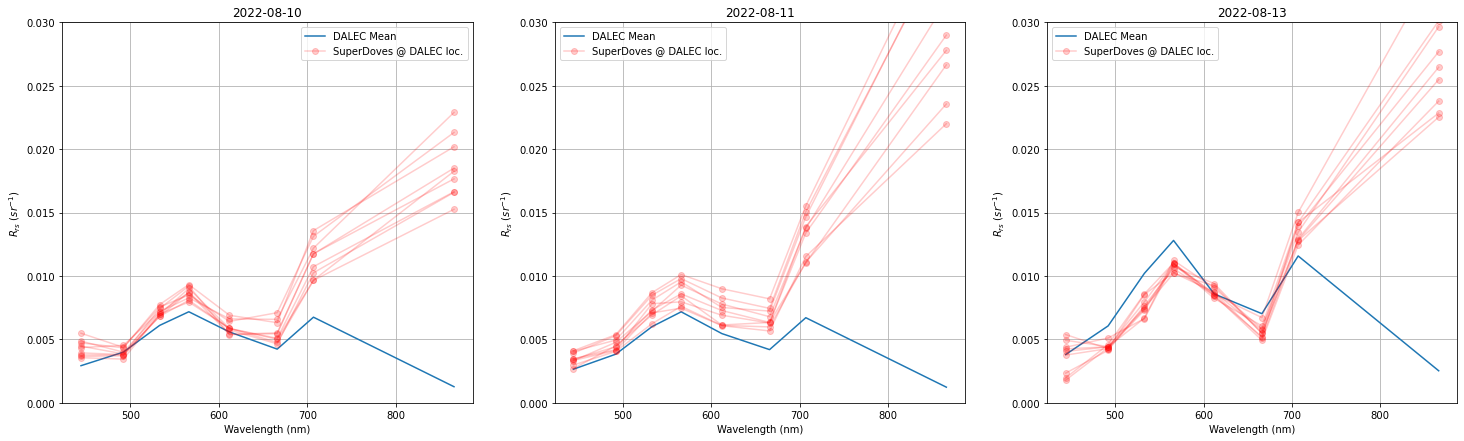

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

for i, date in zip(range(3), superDuperDF.index.get_level_values(0).unique()):
    x = superDuperDF.index.get_level_values(1).unique()
    y = superDuperDF.loc[[date]]['DALEC_mean_Rrs'].values
    ax[i].plot(x, y, label='DALEC Mean')
    for col in list(superDuperDF.columns.values)[1:]:
        y = superDuperDF.loc[[date]][col].values/np.pi
        ax[i].plot(x, y,
                   color='red',
                   label='SuperDoves @ DALEC loc.',
                   marker='o',
                   alpha=0.2)
    ax[i].set_ylim([0, 0.03])
    ax[i].set_title(str(date))
    
    ax[i].set_xlabel('Wavelength (nm)')
    ax[i].set_ylabel('$R_{rs}$ $(sr^{-1}$)')


    # this code removes duplicate labels in the legend. Naughty
    handles, labels = ax[i].get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    ax[i].legend(newHandles, newLabels)

    ax[i].grid()
plt.show()

## Phycoyanin indicator over time

3 days isn't enough data, but we can see that the SD data is too noisy to detect the trend which we see in the DALEC data.

Might be worth repeating this plot at the deeper location, as this hopefully suffers less from adjacency effects and so I hope that the changes in the 707 nm band might be better captured.

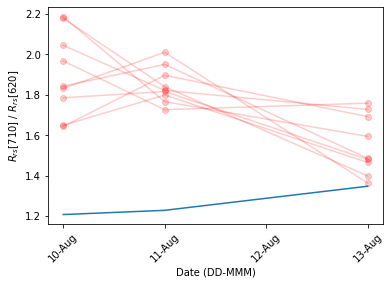

In [107]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

DALEC_612 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],612.0), :]['DALEC_mean_Rrs'].values
DALEC_707 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],707.0), :]['DALEC_mean_Rrs'].values

DALEC_612_707 = DALEC_707/DALEC_612

x = superDuperDF.index.get_level_values(0).unique() # x is the list of dates

plt.plot(x, DALEC_612_707)


for col in list(superDuperDF.columns.values)[1:]:
    SD_612 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],612.0), :][col].values
    SD_707 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],707.0), :][col].values

    SD_612_707 = SD_707/SD_612
    plt.plot(x, SD_612_707,
               color='red',
               label='SuperDoves @ DALEC loc.',
               marker='o',
               alpha=0.2)
    
plt.xticks(rotation = 45)
plt.xlabel('Date (DD-MMM)')
plt.ylabel('$R_{rs}[710]$ / $R_{rs}[620]$')

ax = plt.gca()
date_form = DateFormatter("%d-%b") # DD-MMM format
ax.xaxis.set_major_formatter(date_form) # set format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # make sure that ticks only appear daily
plt.show()

### Match Up Plots (SD vs DALEC)

3 superdoves images isn't really enough for a good DALEC-SD comparison, but here is some code to generate nice comparison plots for each waveband. 

Can already see that we have a lot of variation, but for most wavebands, we aren't too far from the x-y line. 

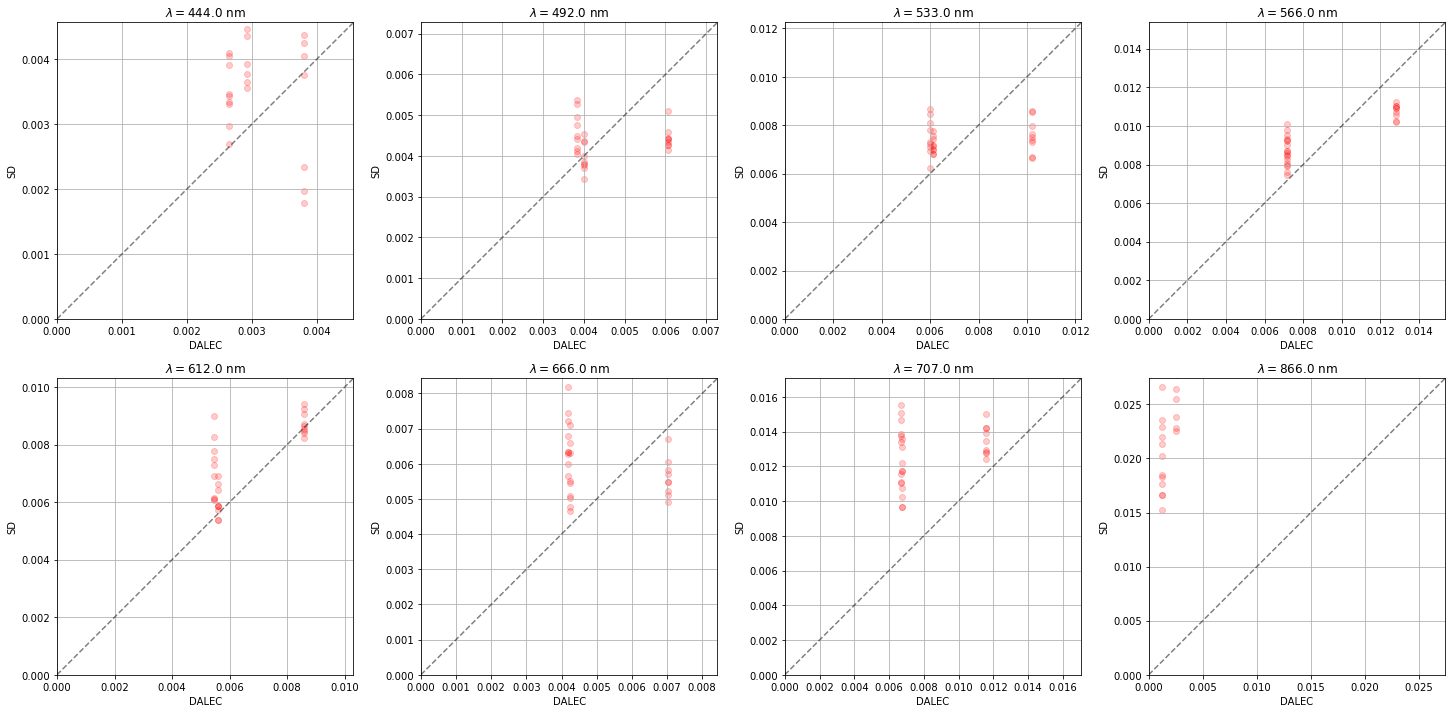

In [138]:
fig, ax = plt.subplots(2, 4, figsize=(25, 12))

ax = ax.flatten()

for i, wavelength in zip(range(8), superDuperDF.index.get_level_values(1).unique()):
    x = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],wavelength), :]['DALEC_mean_Rrs'].values
    #ax[i].scatter(x, y, label='DALEC Mean')
    for col in list(superDuperDF.columns.values)[1:]:
        y = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],wavelength), :][col].values/np.pi
        ax[i].scatter(x, y,
                      color='red',
                      marker='o',
                      alpha=0.2)
    #ax[i].set_ylim([0, 0.03])
    ax[i].set_title('$\lambda = $' + str(wavelength) + ' nm')
    
    ax[i].set_xlabel('DALEC')
    ax[i].set_ylabel('SD')

    ax[i].grid()
    
    max_xy = np.max([x, y])
    
    ax[i].set_ylim([0, max_xy*1.2])
    ax[i].set_xlim([0, max_xy*1.2])
    #plt.axis('equal')
    ax[i].set_aspect('equal', adjustable='box')
    #ax[i].set_aspect('equal', adjustable='datalim', anchor='C')
    ax[i].plot([0, 1], [0, 1], 'k--', alpha=0.5)


plt.show()

In [135]:
print(np.max([x, y])//)
print([x, y])

0.0
[array([0.0012691 , 0.00123217, 0.00252446]), array([0.015256164290640894, 0.022003779319500344, 0.022842882288597183],
      dtype=object)]


In [51]:
superDuperDF.index.get_level_values(1)

Float64Index([444.0, 492.0, 533.0, 566.0, 612.0, 666.0, 707.0, 866.0, 444.0,
              492.0, 533.0, 566.0, 612.0, 666.0, 707.0, 866.0, 444.0, 492.0,
              533.0, 566.0, 612.0, 666.0, 707.0, 866.0],
             dtype='float64', name='Wavelength')

In [64]:
superDuperDF.index.get_level_values(0).unique()

Index([2022-08-10, 2022-08-11, 2022-08-13], dtype='object', name='Date')

In [68]:
superDuperDF.columns.values

array(['DALEC_mean_Rrs', 'rho_s_49_86', 'rho_s_49_87', 'rho_s_49_88',
       'rho_s_50_86', 'rho_s_50_87', 'rho_s_50_88', 'rho_s_51_86',
       'rho_s_51_87', 'rho_s_51_88'], dtype=object)